In [1]:
# load all necessary functions
from IPython.display import Markdown, display, HTML
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
# load dataset into dataframe
df = pd.read_csv("Bank_Churn.csv")
df.head()

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.describe()

,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


## We create a function to perform eda on the dataset

In [6]:
def perform_eda(data, target_column=None, num_bins=20):
    """
    Performs exploratory data analysis (EDA) on a dataset.

    Args:
        data (pd.DataFrame): The dataset to analyze.
        target_column (str, optional): Name of the target column for analysis. Defaults to None.
        num_bins (int, optional): Number of bins for histograms. Defaults to 20.

    Returns:
        None: Displays EDA results including statistics, distributions, and visualizations.
    """
    print("===== EDA Summary =====\n")
    
    # 1. Basic Information
    print("1. Basic Information:")
    print(f"Shape of dataset: {data.shape}")
    print("\nData Types:\n", data.dtypes)
    print("\nSample Data:\n", data.head(), "\n")

    # 2. Check for Missing Values
    print("2. Missing Values:")
    missing_values = data.isnull().sum()
    if missing_values.any():
        print(missing_values[missing_values > 0], "\n")
    else:
        print("No missing values detected.\n")
    
    # 3. Summary Statistics
    print("3. Summary Statistics:")
    print(data.describe(include='all'), "\n")

    # 4. Target Column Analysis
    if target_column and target_column in data.columns:
        print(f"4. Target Column Analysis: {target_column}")
        if data[target_column].dtype == 'object':
            # If the target column is categorical
            print("\nValue Counts:\n", data[target_column].value_counts(), "\n")
            try:
                plt.figure(figsize=(8, 4))
                sns.countplot(y=target_column, data=data, order=data[target_column].value_counts().index)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()  # Adjust layout to prevent overlap
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
        elif data[target_column].dtype in ['int64', 'float64']:
            # If the target column is numeric (int64 or float64)
            try:
                sns.histplot(data[target_column], kde=True, bins=num_bins)
                plt.title(f'Distribution of Target Column: {target_column}')
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting target column: {e}")
    else:
        print("No target column specified or invalid target column.")

    # 5. Visualizations for Numeric Features
    print("5. Numeric Feature Distributions:")
    numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns
    if len(numeric_columns) > 0:
        try:
            data[numeric_columns].hist(figsize=(12, 8), bins=num_bins)
            plt.suptitle("Numeric Feature Distributions", fontsize=16)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting numeric distributions: {e}")
    else:
        print("No numeric column found to plot")

    # 6. Correlation Heatmap
    print("6. Correlation Analysis:")
    if len(numeric_columns) > 0:
        try:
            correlation_matrix = data[numeric_columns].corr()
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap")
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error plotting heatmap: {e}")
    else:
        print("No numeric column found to perform correlation")

    # 7. Categorical Feature Analysis
    print("7. Categorical Features:")
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    if len(categorical_columns) > 0:
        for column in categorical_columns:
            try:
                print(f"\nValue Counts for {column}:\n", data[column].value_counts())
                plt.figure(figsize=(8, 4))
                sns.countplot(y=column, data=data, order=data[column].value_counts().index)
                plt.title(f"Distribution of {column}")
                plt.tight_layout()
                plt.show()
            except Exception as e:
                print(f"Error plotting {column}: {e}")
    else:
        print("No categorical features found.")

    print("\n===== EDA Complete =====")


===== EDA Summary =====

1. Basic Information:
Shape of dataset: (10000, 13)

Data Types:
 CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

Sample Data:
    CustomerId   Surname  CreditScore Geography  Gender  Age  Tenure  \
0    15634602  Hargrave          619    France  Female   42       2   
1    15647311      Hill          608     Spain  Female   41       1   
2    15619304      Onio          502    France  Female   42       8   
3    15701354      Boni          699    France  Female   39       1   
4    15737888  Mitchell          850     Spain  Female   43       2   

     Balance  NumOfProducts  HasCrCard  IsActiveMember  EstimatedSalary  \
0       0.00              1

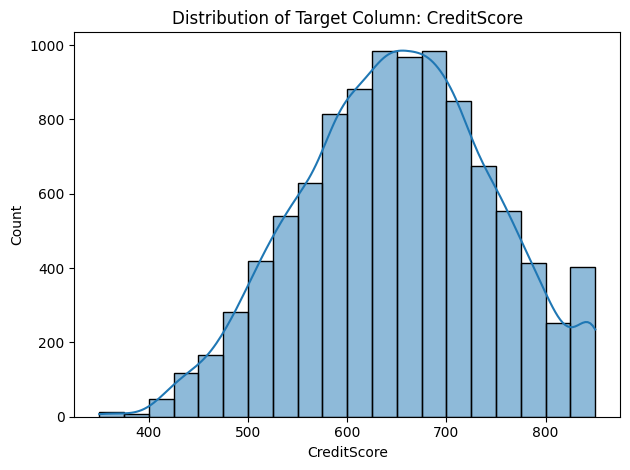

5. Numeric Feature Distributions:


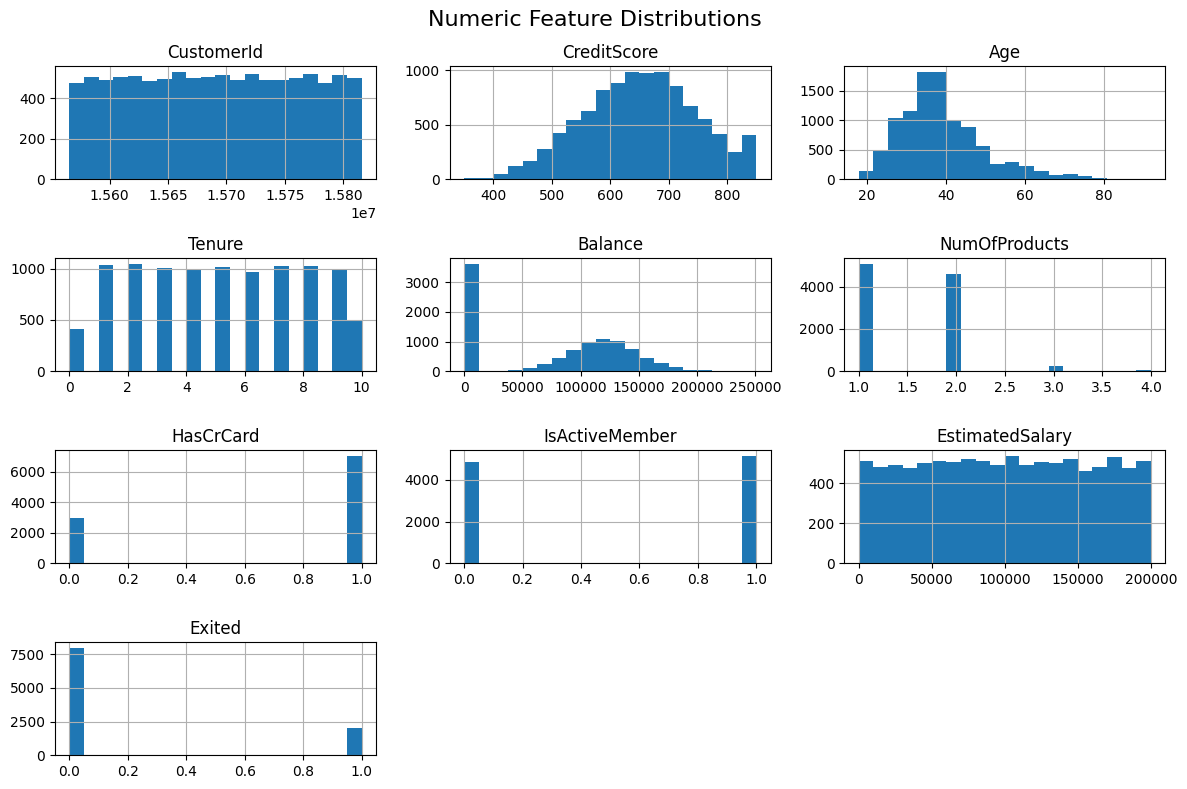

6. Correlation Analysis:


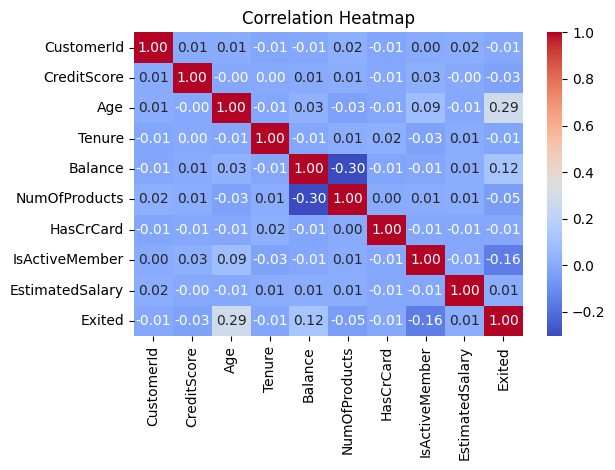

7. Categorical Features:

Value Counts for Surname:
 Surname
Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: count, Length: 2932, dtype: int64


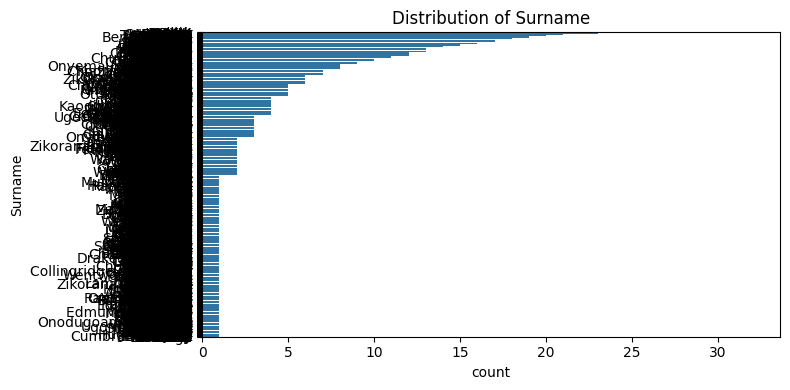


Value Counts for Geography:
 Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64


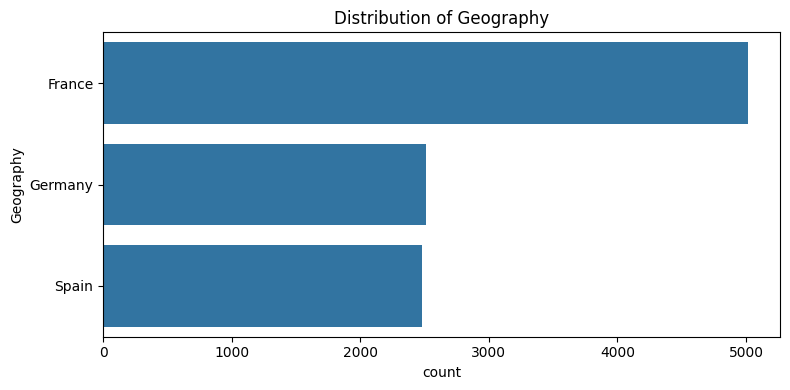


Value Counts for Gender:
 Gender
Male      5457
Female    4543
Name: count, dtype: int64


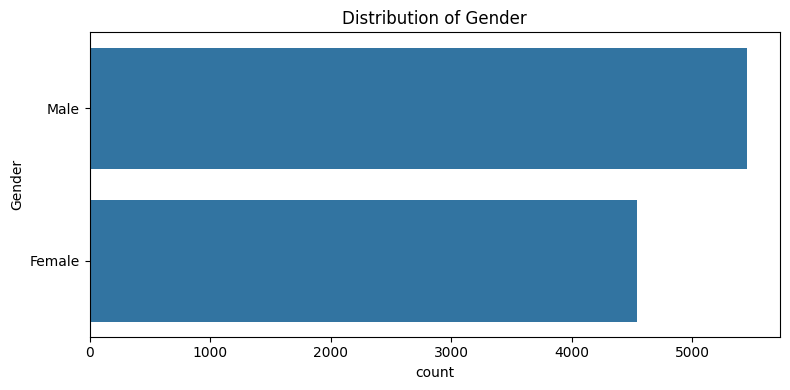


===== EDA Complete =====


In [5]:
perform_eda(df, target_column='CreditScore')


In [5]:
info = df.info()
print(info)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB
None


In [3]:
# Make a copy of the DataFrame
df_copy = df.copy()

In [4]:
df_copy.columns

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age',
       'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Exited'],
      dtype='object')

In [5]:
# checking our target variable
df_copy['Exited'].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [6]:
# split the data into predictor and target
y = df_copy['Exited']
X = df_copy[['CreditScore', 'Gender', 'Age', 'Tenure', 'Balance', 'IsActiveMember']]

# change the categorical columns into numerical
X_transformed = pd.get_dummies(X, drop_first=True)

# Standardizing the data (important for models like Logistic Regression)
scaler = StandardScaler()
#scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_transformed)

# Split the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)


# Training with a logistic regression model

In [7]:
# training with logistic regression
lm = LogisticRegression() #  Initialize, train the Logistic Regression model
lm.fit(X_train, y_train)

# Make predictions
y_pred = lm.predict(X_test)

In [8]:
# extracting coefficients
a = float(lm.intercept_)
b = lm.coef_

# converting the coefficients into a dataframe
coeff_df = pd.DataFrame(lm.coef_.T, X_transformed.columns, columns=['Coefficient'])

display(HTML(f"1. The intercept is: {a}"))
display(HTML(f"\n2. The coefficients of the data is: "))
print(coeff_df)

C:\Users\alber\AppData\Local\Temp\ipykernel_22872\2596279634.py:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  a = float(lm.intercept_)


                Coefficient
CreditScore       -0.075835
Age                0.736915
Tenure            -0.065347
Balance            0.322723
IsActiveMember    -0.520806
Gender_Male       -0.266397


In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)

Accuracy: 0.816060606060606
Confusion Matrix:
[[2585   72]
 [ 535  108]]
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      2657
           1       0.60      0.17      0.26       643

    accuracy                           0.82      3300
   macro avg       0.71      0.57      0.58      3300
weighted avg       0.78      0.82      0.77      3300



# training another model to test its effectiveness

In [10]:

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_train, y_train)

# Predict the target values using the test data
gen_y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, gen_y_pred)
conf_matrix = confusion_matrix(y_test, gen_y_pred)
class_report = classification_report(y_test, gen_y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.8275757575757576
Confusion Matrix:
[[2505  152]
 [ 417  226]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90      2657
           1       0.60      0.35      0.44       643

    accuracy                           0.83      3300
   macro avg       0.73      0.65      0.67      3300
weighted avg       0.81      0.83      0.81      3300



# correcting the imbalances using
1. SMOTE
2. RANDOM OVERSAMPLING

In [11]:
# using SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state = 42) 

X_smote, y_smote = smote.fit_resample(X_train,y_train)

<Axes: xlabel='Exited'>

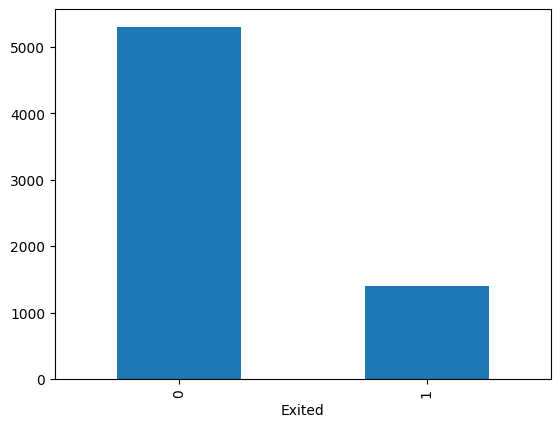

In [16]:
y_train.value_counts().plot.bar()

<Axes: xlabel='Exited'>

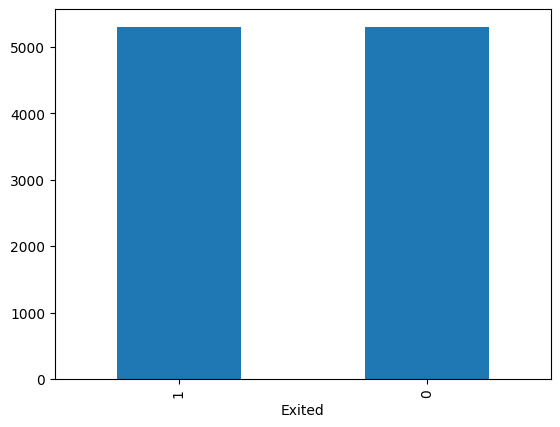

In [15]:
# checking the balances
y_smote.value_counts().plot.bar()

In [29]:

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_smote, y_smote)

# Predict the target values using the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.786060606060606
Confusion Matrix:
[[2294  363]
 [ 343  300]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.87      2657
           1       0.45      0.47      0.46       643

    accuracy                           0.79      3300
   macro avg       0.66      0.66      0.66      3300
weighted avg       0.79      0.79      0.79      3300



In [30]:
# using Random over sampler
from imblearn.over_sampling import RandomOverSampler

o_smpl = RandomOverSampler(random_state = 42) 

X_o_smpl, y_o_smpl = o_smpl.fit_resample(X_train,y_train)


In [32]:

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model on the training data
rf_classifier.fit(X_o_smpl, y_o_smpl)

# Predict the target values using the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
class_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(conf_matrix)
print("Classification Report:")
print(class_report)


Accuracy: 0.8048484848484848
Confusion Matrix:
[[2382  275]
 [ 369  274]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88      2657
           1       0.50      0.43      0.46       643

    accuracy                           0.80      3300
   macro avg       0.68      0.66      0.67      3300
weighted avg       0.79      0.80      0.80      3300



<Axes: xlabel='Exited'>

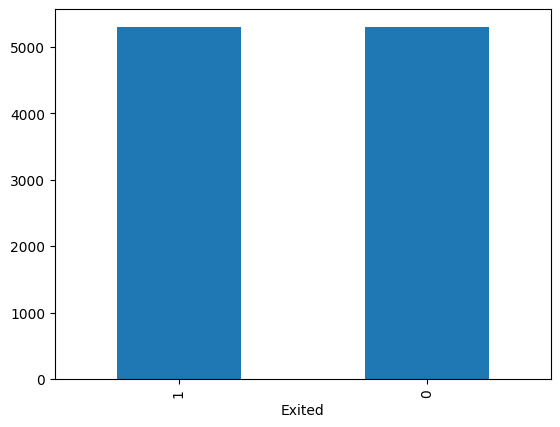

In [33]:
y_o_smpl.value_counts().plot.bar()

# What to deduce and learn!
1. the accuracy of both models is about 0.828
2. this is great but there is a great imbalance in the data
3. the f1_score is a great harmonic balance
4. smote and other techniques can be used to balance and improve model